In [50]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
from collections import Counter
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

The dataset provided has the following columns of multiple-choice data:

- body_type
- diet
- drinks
- drugs
- education
- ethnicity
- height
- income
- job
- offspring
- orientation
- pets
- religion
- sex
- sign
- smokes
- speaks
- status

And a set of open short-answer responses to :

- essay0 - My self summary
- essay1 - What I’m doing with my life
- essay2 - I’m really good at
- essay3 - The first thing people usually notice about me
- essay4 - Favorite books, movies, show, music, and food
- essay5 - The six things I could never do without
- essay6 - I spend a lot of time thinking about
- essay7 - On a typical Friday night I am
- essay8 - The most private thing I am willing to admit
- essay9 - You should message me if…

In [3]:
profiles = pd.read_csv("profiles.csv")
print(profiles.head())

   age       body_type               diet    drinks      drugs  \
0   22  a little extra  strictly anything  socially      never   
1   35         average       mostly other     often  sometimes   
2   38            thin           anything  socially        NaN   
3   23            thin         vegetarian  socially        NaN   
4   29        athletic                NaN  socially      never   

                           education  \
0      working on college/university   
1              working on space camp   
2     graduated from masters program   
3      working on college/university   
4  graduated from college/university   

                                              essay0  \
0  about me:<br />\n<br />\ni would love to think...   
1  i am a chef: this is what that means.<br />\n1...   
2  i'm not ashamed of much, but writing public te...   
3          i work in a library and go to school. . .   
4  hey how's it going? currently vague on the pro...   

                         

Let's make sure we understand what these columns represent!

Pick some columns and call `.head()` on them to see the first five rows of data. For example, we were curious about `job`, so we called:

In [4]:
print(100*profiles['education'].value_counts()/len(profiles))

graduated from college/university    39.967638
graduated from masters program       14.948454
working on college/university         9.528576
working on masters program            2.807527
graduated from two-year college       2.553965
graduated from high school            2.382144
graduated from ph.d program           2.121910
graduated from law school             1.871685
working on two-year college           1.791612
dropped out of college/university     1.659827
working on ph.d program               1.639809
college/university                    1.336203
graduated from space camp             1.095986
dropped out of space camp             0.872452
graduated from med school             0.744003
working on space camp                 0.742335
working on law school                 0.448737
two-year college                      0.370333
working on med school                 0.353652
dropped out of two-year college       0.318620
dropped out of masters program        0.233544
masters progr

For example, we were curious about the distribution of ages on the site, so we made a histogram of the `age` column:

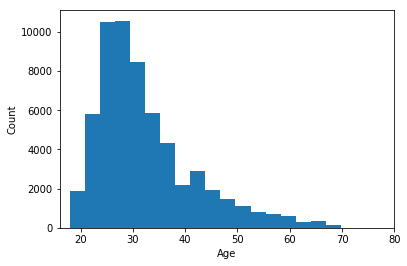

In [5]:
plt.hist(profiles.age, bins=32)
plt.xlabel("Age")
plt.ylabel("Count")
plt.xlim(16, 80)
plt.show()

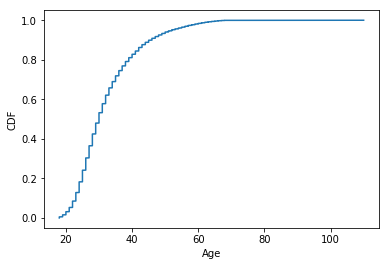

In [6]:
#hist, bins = np.histogram(profiles.age, bins=32, normed=True)
#bin_centers = (bins[1:]+bins[:-1])*0.5

x_ = profiles.age.sort_values(inplace = False, ascending = True)
y_ = np.linspace(0,1,len(x_))

plt.plot(x_, y_)
plt.xlabel("Age")
plt.ylabel("CDF")
plt.show()

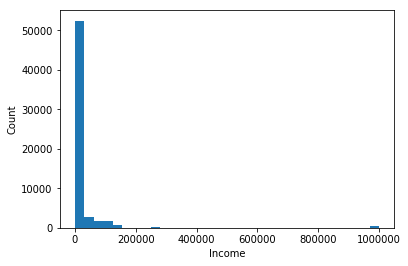

In [7]:
plt.hist(profiles.income, bins=32)
plt.xlabel("Income")
plt.ylabel("Count")
plt.show()

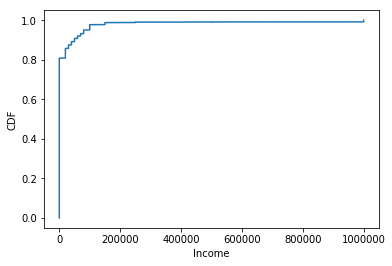

In [8]:
x_ = profiles.income.sort_values(inplace = False, ascending = True)
y_ = np.linspace(0,1,len(x_))

plt.plot(x_, y_)
plt.xlabel("Income")
plt.ylabel("CDF")
plt.show()

In [9]:
profiles.income.value_counts()

-1          48442
 20000       2952
 100000      1621
 80000       1111
 30000       1048
 40000       1005
 50000        975
 60000        736
 70000        707
 150000       631
 1000000      521
 250000       149
 500000        48
Name: income, dtype: int64

In [10]:
drink_mapping = {"not at all": 0, "rarely": 1, "socially": 2, "often": 3, "very often": 4, "desperately": 5}
profiles["drinks_code"] = profiles.drinks.map(drink_mapping)

drugs_mapping = {"never": 0, "sometimes": 1, "often": 2}
profiles["drugs_code"] = profiles.drugs.map(drugs_mapping)

smokes_mapping = {"no": 0, "sometimes": 1, "when drinking": 2, "yes": 3, "trying to quit": 4}
profiles["smokes_code"] = profiles.smokes.map(smokes_mapping)

income_map = []
for profile_ in profiles['income']:
    if profile_ < 0:
        income_map.append(np.nan)
    else:
        income_map.append(profile_)
profiles["adj_income"] = income_map

In [11]:
income_mapping_2 = {-1: np.nan, 
                    20000: 0, 30000: 0, 40000: 0,
                    50000: 1, 60000: 1, 70000: 1, 80000: 1, 100000: 1,
                    150000: 2, 250000: 2,
                    500000: 3, 1000000: 3,}
profiles["income_code"] = profiles.income.map(income_mapping_2)

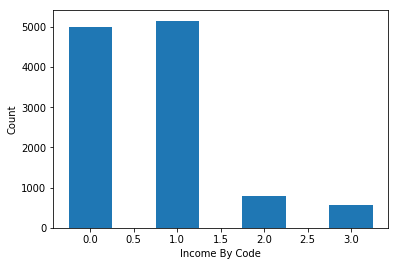

In [12]:
plt.hist(profiles.income_code, bins=[-0.25,0.25,0.75,1.25,1.75,2.25,2.75,3.25])
plt.xlabel("Income By Code")
plt.ylabel("Count")
plt.show()

In [13]:
edu_mapping = {"graduated from college/university": 3, 
               "graduated from masters program": 4, 
               "working on college/university": 3, 
               "working on masters program": 4, 
               "graduated from two-year college": 2, 
               "graduated from high school": 1,
               "graduated from ph.d program": 5,
               "graduated from law school": 5,
               "working on two-year college": 2,
               "dropped out of college/university": 1,
               "working on ph.d program": 5,
               "college/university": 3,
               "graduated from space camp": np.nan,
               "dropped out of space camp": np.nan,
               "graduated from med school": 5,
               "working on space camp": np.nan,
               "working on law school": 5,
               "two-year college": 2,
               "working on med school": 5,
               "dropped out of two-year college": 1,
               "dropped out of masters program": 3,
               "masters program": 4,
               "dropped out of ph.d program": 3,
               "dropped out of high school": 0,
               "high school": 1,
               "working on high school": 1,
               "space camp": np.nan,
               "ph.d program": 5,
               "law school": 5,
               "dropped out of law school": 3,
               "dropped out of med school": 3,
               "med school": 5}
profiles["enum_education"] = profiles.education.map(edu_mapping)
print(profiles["enum_education"][1:10])

1    NaN
2    4.0
3    3.0
4    3.0
5    3.0
6    3.0
7    3.0
8    3.0
9    2.0
Name: enum_education, dtype: float64


We also wanted some numerical data about the short answer essays. We combined them all into one string, took out the `NaN`s, and then created a new column called `essay_len`:

In [14]:
essay_cols = ["essay0","essay1","essay2","essay3","essay4","essay5","essay6","essay7","essay8","essay9"]


# Removing the NaNs
all_essays = profiles[essay_cols].replace(np.nan, '', regex=True)
# Remove <br> html stuff
all_essays = all_essays.replace('<br />', ' ', regex=True)
all_essays = all_essays.replace('\n', ' ', regex=True)
all_essays = all_essays.replace('\ni', ' ', regex=True)
all_essays = all_essays.replace('\n1', ' ', regex=True)
# Combining the essays
all_essays = all_essays[essay_cols].apply(lambda x: ' '.join(x), axis=1)


profiles["essay_len"] = all_essays.apply(lambda x: len(x))

In [15]:
print(all_essays.head())

0    about me:    i would love to think that i was ...
1    i am a chef: this is what that means.  1. i am...
2    i'm not ashamed of much, but writing public te...
3    i work in a library and go to school. . . read...
4    hey how's it going? currently vague on the pro...
dtype: object


In [16]:
avg_word_length = []
num_I_or_me = []
for essay in all_essays:
    if essay:
        words = re.split(r'[^0-9A-Za-z]+',essay)
        wordLength = 0
        IorME = 0
        for word in words:
            wordLength += len(word)
            if word.lower() == "i" or word.lower() == "me":
                IorME += 1      
        avgWordLength = wordLength / len(words)
    else:
        avgWordLength = 0
    avg_word_length.append(avgWordLength)
    num_I_or_me.append(IorME)

In [17]:
profiles["avg_word_length"] = avg_word_length
profiles["num_I_or_me"] = num_I_or_me

In [18]:
from collections import Counter
# enumEducation = enumerate(Counter(profiles['education']), 0)
#eduEnum = []

#for profile_ in profiles['education']:
#    c = np.nan
#    for count, item in enumerate(Counter(profiles['education']), 0):
#        if profile_ == item:
#            c = count
#    eduEnum.append(c)
#profiles["enum_education"] = eduEnum

### Normalize your Data!


In order to get accurate results, we should make sure our numerical data all has the same weight.


For our Zodiac features, we used:

In [19]:
profiles['sex_01'] = profiles['sex'].map({'m':0,'f':1})
profiles_nonan = profiles.dropna(subset=['sex_01', 'smokes_code', 'drinks_code', 'drugs_code', 'essay_len', 'avg_word_length','num_I_or_me','enum_education', 'adj_income', 'income_code'])

# feature_data = profiles_nonan[['smokes_code', 'drinks_code', 'drugs_code', 'essay_len', 'avg_word_length','num_I_or_me','enum_education']]
feature_data = profiles_nonan[['enum_education', 'income_code']]
feature_data2 = profiles_nonan[['essay_len', 'avg_word_length']]
feature_data3 = profiles_nonan[['income_code']]
labels = profiles_nonan['sex_01']
labels2 = profiles_nonan['enum_education']
labels3 = profiles_nonan['enum_education']

x = feature_data.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

feature_data = pd.DataFrame(x_scaled, columns=feature_data.columns)

In [20]:
colors_ = []
for label_ in labels:
    if label_:
        colors_.append('red')
    else:
        colors_.append('blue')

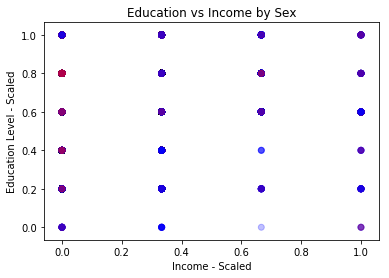

In [21]:
plt.scatter(feature_data['income_code'],feature_data['enum_education'],c=colors_, alpha=0.25)
plt.xlabel('Income - Scaled')
plt.ylabel('Education Level - Scaled')
plt.title('Education vs Income by Sex')
plt.show()

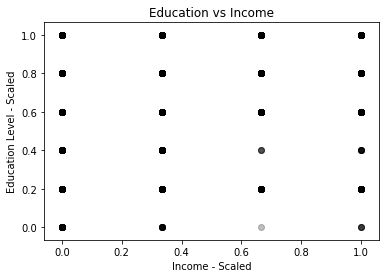

In [22]:
plt.scatter(feature_data['income_code'],feature_data['enum_education'],c='black', alpha=0.25)
plt.xlabel('Income - Scaled')
plt.ylabel('Education Level - Scaled')
plt.title('Education vs Income')
plt.show()

6768
0.6934435912581217
0.07623999999999853


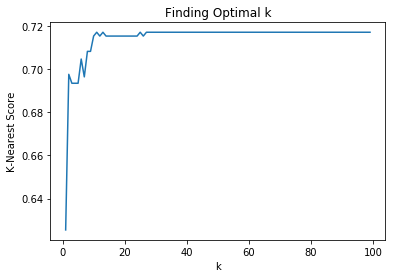

In [23]:
train_data, test_data, train_labels, test_labels = train_test_split(feature_data, labels, test_size=0.2, random_state=1)
print(len(train_data))
classifier = KNeighborsClassifier(n_neighbors=5)
t = time.process_time()
classifier.fit(train_data, train_labels)
elapsed_time = time.process_time() - t
print(classifier.score(test_data, test_labels))
print(elapsed_time)
scores = []
for k in range(1,100):
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(train_data, train_labels)
    scores.append(classifier.score(test_data, test_labels))
plt.plot(range(1,100), scores)
plt.xlabel('k')
plt.ylabel('K-Nearest Score')
plt.title('Finding Optimal k')
plt.show()

In [39]:
classifier = SVC(gamma=3,C=1)
t = time.process_time()
classifier.fit(train_data, train_labels)
elapsed_time = time.process_time() - t
print(elapsed_time)
print(classifier.score(test_data, test_labels))
scores = []
cnt = 0
for g_ in range(1,10):
    for c_ in range(1,10):
        cnt += 1
        classifier = SVC(gamma=g_,C=c_)
        classifier.fit(train_data, train_labels)
        scores.append(classifier.score(test_data, test_labels))

1.503975999999966
0.7141169521559362


In [42]:
print(cnt)
print(len(scores))
print(len(range(cnt)))

81
81
81


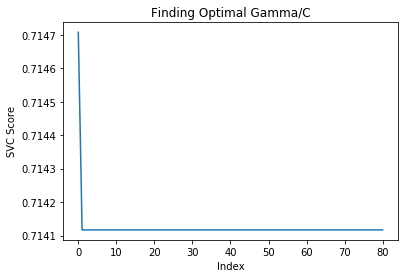

In [44]:
plt.plot(range(cnt), scores)
plt.xlabel('Index')
plt.ylabel('SVC Score')
plt.title('Finding Optimal Gamma/C')
plt.show()

In [25]:
classifier = MultinomialNB()
t = time.process_time()
classifier.fit(train_data, train_labels)
elapsed_time = time.process_time() - t
print(elapsed_time)
print(classifier.score(test_data, test_labels))

0.009689999999991983
0.7152982870643827


6768
0.01165999999999201
0.4477259303012404


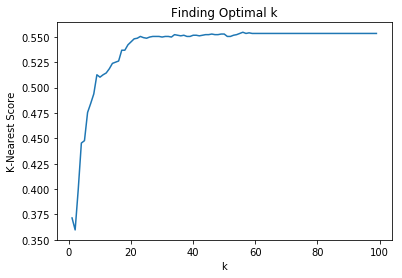

In [26]:
train_data, test_data, train_labels, test_labels = train_test_split(feature_data2, labels2, test_size=0.2, random_state=1)
print(len(train_data))
classifier = KNeighborsClassifier(n_neighbors=5)
t = time.process_time()
classifier.fit(train_data, train_labels)
elapsed_time = time.process_time() - t
print(elapsed_time)
print(classifier.score(test_data, test_labels))
scores = []
for k in range(1,100):
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(train_data, train_labels)
    scores.append(classifier.score(test_data, test_labels))
plt.plot(range(1,100), scores)
plt.xlabel('k')
plt.ylabel('K-Nearest Score')
plt.title('Finding Optimal k')
plt.show()

1.4679479999999785
0.7141169521559362


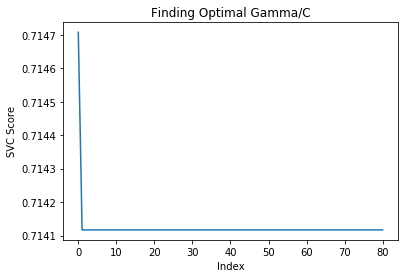

In [46]:
classifier = SVC(gamma=3,C=1)
t = time.process_time()
classifier.fit(train_data, train_labels)
elapsed_time = time.process_time() - t
print(elapsed_time)
print(classifier.score(test_data, test_labels))
scores = []
cnt = 0
for g_ in range(1,10):
    for c_ in range(1,10):
        cnt += 1
        classifier = SVC(gamma=g_,C=c_)
        classifier.fit(train_data, train_labels)
        scores.append(classifier.score(test_data, test_labels))
plt.plot(range(cnt), scores)
plt.xlabel('Index')
plt.ylabel('SVC Score')
plt.title('Finding Optimal Gamma/C')
plt.show()

In [28]:
classifier = MultinomialNB()
t = time.process_time()
classifier.fit(train_data, train_labels)
elapsed_time = time.process_time() - t
print(elapsed_time)
print(classifier.score(test_data, test_labels))

0.013902000000001635
0.5516834022445364


6768
0.05170800000000497
0.33195510927347904


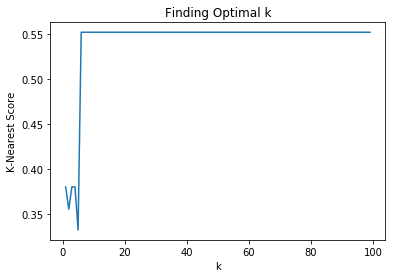

In [29]:
train_data, test_data, train_labels, test_labels = train_test_split(feature_data3, labels3, test_size=0.2, random_state=1)
print(len(train_data))
classifier = KNeighborsClassifier(n_neighbors=5)
t = time.process_time()
classifier.fit(train_data, train_labels)
elapsed_time = time.process_time() - t
print(elapsed_time)
print(classifier.score(test_data, test_labels))
scores = []
for k in range(1,100):
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(train_data, train_labels)
    scores.append(classifier.score(test_data, test_labels))
plt.plot(range(1,100), scores)
plt.xlabel('k')
plt.ylabel('K-Nearest Score')
plt.title('Finding Optimal k')
plt.show()

In [30]:
classifier = SVC(gamma=3,C=1)
t = time.process_time()
classifier.fit(train_data, train_labels)
elapsed_time = time.process_time() - t
print(elapsed_time)
print(classifier.score(test_data, test_labels))

1.9759659999999997
0.5534554046072061


In [31]:
classifier = MultinomialNB()
t = time.process_time()
classifier.fit(train_data, train_labels)
elapsed_time = time.process_time() - t
print(elapsed_time)
print(classifier.score(test_data, test_labels))

0.013428000000004658
0.5534554046072061


In [47]:
model = LinearRegression()
train_data, test_data, train_labels, test_labels = train_test_split(feature_data, labels, test_size=0.2, random_state=1)
model.fit(train_data, train_labels)
print(model.score(train_data, train_labels))
print(model.score(test_data, test_labels))

0.026160779658499615
0.030409108509710455


-0.7303578193663229
-0.7503552980088051


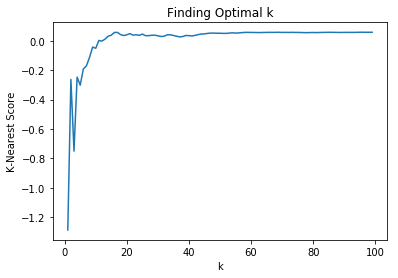

In [54]:
model = KNeighborsRegressor(n_neighbors = 3)
model.fit(train_data, train_labels)
print(model.score(train_data, train_labels))
print(model.score(test_data, test_labels))
scores = []
for k in range(1,100):
    classifier = KNeighborsRegressor(n_neighbors = k)
    classifier.fit(train_data, train_labels)
    scores.append(classifier.score(test_data, test_labels))
plt.plot(range(1,100), scores)
plt.xlabel('k')
plt.ylabel('K-Nearest Score')
plt.title('Finding Optimal k')
plt.show()

In [55]:
model = LinearRegression()
train_data, test_data, train_labels, test_labels = train_test_split(feature_data2, labels2, test_size=0.2, random_state=1)
model.fit(train_data, train_labels)
print(model.score(train_data, train_labels))
print(model.score(test_data, test_labels))

0.013511601379598503
0.008523467137894092


0.33459858733320413
-0.3196641844350345


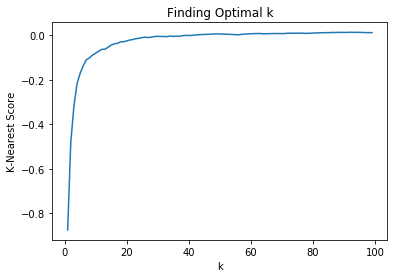

In [56]:
model = KNeighborsRegressor(n_neighbors = 3)
model.fit(train_data, train_labels)
print(model.score(train_data, train_labels))
print(model.score(test_data, test_labels))
scores = []
for k in range(1,100):
    classifier = KNeighborsRegressor(n_neighbors = k)
    classifier.fit(train_data, train_labels)
    scores.append(classifier.score(test_data, test_labels))
plt.plot(range(1,100), scores)
plt.xlabel('k')
plt.ylabel('K-Nearest Score')
plt.title('Finding Optimal k')
plt.show()

In [57]:
model = LinearRegression()
train_data, test_data, train_labels, test_labels = train_test_split(feature_data3, labels3, test_size=0.2, random_state=1)
model.fit(train_data, train_labels)
print(model.score(train_data, train_labels))
print(model.score(test_data, test_labels))

0.05088156934165744
0.03835699181530084


-0.7303578193663229
-0.7503552980088051


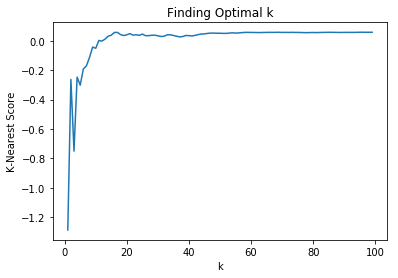

In [58]:
model = KNeighborsRegressor(n_neighbors = 3)
model.fit(train_data, train_labels)
print(model.score(train_data, train_labels))
print(model.score(test_data, test_labels))
scores = []
for k in range(1,100):
    classifier = KNeighborsRegressor(n_neighbors = k)
    classifier.fit(train_data, train_labels)
    scores.append(classifier.score(test_data, test_labels))
plt.plot(range(1,100), scores)
plt.xlabel('k')
plt.ylabel('K-Nearest Score')
plt.title('Finding Optimal k')
plt.show()